In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
class Model(nn.Module):
    
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__(*args, **kwargs)
        
        self.fc1 = nn.Linear(10, 10)

In [3]:
class IPS(optim.Optimizer):
    def __init__(self, model_params, T, lower_bound, step_decay=False, initial_decay=0):
        
        defaults = dict(T=T, lower_bound=lower_bound, step_decay=step_decay)
        
        super(IPS, self).__init__(model_params, defaults)
        
        self.best_loss = float('inf')
        self.best_params = None
        self.step_count = T * initial_decay
        
        
    @torch.no_grad()
    def step(self, closure=None):
        
        self.step_count += 1
        if closure is not None:
            with torch.enable_grad():
                rtloss = closure()
                loss = rtloss.item()
                
        for group in self.param_groups:
            T = group['T']
            l_star = group['lower_bound']
            step_decay = group['step_decay']
            # boost convergence during initial stages
            current_t = min(self.step_count, T)
            
            for param in group['params']:
                if param.grad is None:
                    continue
                
                grad = param.grad.data
                grad_norm_sq = torch.sum(grad ** 2) + 1e-8
                
                inexact_step_size = (loss - l_star) / (grad_norm_sq * ((current_t if step_decay else T) ** 0.5))
                
                # important, since we're using incremental stepsize without clamping gradient explodes
                # especially true in earlier steps
                inexact_step_size = torch.clamp(inexact_step_size, min=0.0, max=1.0)
                param.data.add_(grad, alpha=-inexact_step_size)
                
        if loss < self.best_loss:
            self.best_loss = loss
            self.best_params = [p.clone().detach() for p in self.param_groups[0]['params']]
                
        return rtloss
    
    def load_best_params(self):
        if self.best_params:
            for param, best_param in zip(self.param_groups[0]['params'], self.best_params):
                param.data.copy_(best_param)
                

In [ ]:
class AdaIPS(optim.Optimizer):
    def __init__(self, model_params, T, lower_bound, lambda_t, beta_1, beta_2):
        
        defaults = dict(lower_bound=lower_bound)
        
        super(AdaIPS, self).__init__(model_params, defaults)
        
        self.best_loss = float('inf')
        self.best_params = None
        self.T0 = T
        self.lambda_t = lambda_t
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.t = 0
                
        
        
    @torch.no_grad()
    def step(self, closure=None):
        self.t += 1
        if closure is not None:
            with torch.enable_grad():
                rtloss = closure()
                loss = rtloss.item()
                
        for group in self.param_groups:
            l_star = group['lower_bound']

            
            
            for param in group['params']:
                if param.grad is None:
                    continue
                
                if not hasattr(param, 'v_t'):
                    param.v_t = torch.zeros_like(param)
                    
                if not hasattr(param, 'm_t'):
                    param.m_t = torch.zeros_like(param)
                
                grad = param.grad.data
                grad_norm_sq = torch.sum(grad ** 2).clamp(min=1e-8)
                
                param.v_t = self.beta_2 * param.v_t + (1 - self.beta_2) * grad ** 2
                param.m_t = self.beta_1 * param.m_t + (1 - self.beta_1) * grad

                m_t_hat = param.m_t / (1 - self.beta_1 ** self.t)
                v_t_hat = param.v_t / (1 - self.beta_2 ** self.t)
                
                # Calculate norm of gradient for step size
                grad_norm_sq = torch.sum(grad ** 2).clamp(min=1e-8)
                
                # Compute adaptive T_t based on corrected second moments
                T_t = self.T0 + self.lambda_t * param.v_t
                
                # Calculate inexact proximal step size
                inexact_step_size = (loss - l_star) / (grad_norm_sq * (T_t ** 0.5))
                
                # Clamp step size for stability
                inexact_step_size = inexact_step_size.clamp(min=0.0, max=1.0)
                
                # Apply update using momentum direction
                param.data.add_(m_t_hat, alpha=-inexact_step_size)
                
        # if loss < self.best_loss:
        #     self.best_loss = loss
        #     self.best_params = [p.clone().detach() for p in self.param_groups[0]['params']]
                
        return rtloss
    
    def load_best_params(self):
        if self.best_params:
            for param, best_param in zip(self.param_groups[0]['params'], self.best_params):
                param.data.copy_(best_param)
                

In [5]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.losses = []
        

    def forward(self, x):
        x = x.view(-1, 28*28).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [6]:
epochs = 5
batch_size = 64

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(trainset), shuffle=True)

In [8]:
def train(model, optimizer, epochs=2):
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = epochs
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

            loss = optimizer.step(closure)

            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
            model.losses.append(loss.item())

    print("Training complete.")
    return model

In [9]:
def test(model):
    for i, (inputs, labels) in enumerate(testloader):
        output = model(inputs)
        output = output.argmax(axis=1)
        print(accuracy_score(labels, output.detach().numpy()))

In [58]:
adaIpsModel = SimpleNN().to(device)
adaIpsOptimizer = AdaIPS(adaIpsModel.parameters(), T=1, lower_bound=0, beta_1=0.9, beta_2=0.99, lambda_t=10)
train(adaIpsModel, adaIpsOptimizer, epochs=epochs)

AdaIPS (
Parameter Group 0
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.315218210220337
Epoch 1, Step 100, Loss: 0.6182899475097656
Epoch 1, Step 200, Loss: 0.544367790222168
Epoch 1, Step 300, Loss: 0.3467074930667877
Epoch 1, Step 400, Loss: 0.2731066942214966
Epoch 1, Step 500, Loss: 0.30375489592552185
Epoch 1, Step 600, Loss: 0.21336230635643005
Epoch 1, Step 700, Loss: 0.19102506339550018
Epoch 1, Step 800, Loss: 0.07217384874820709
Epoch 1, Step 900, Loss: 0.21645820140838623
Epoch 2, Step 0, Loss: 0.13544724881649017
Epoch 2, Step 100, Loss: 0.1918986439704895
Epoch 2, Step 200, Loss: 0.09846553206443787
Epoch 2, Step 300, Loss: 0.18640156090259552
Epoch 2, Step 400, Loss: 0.22619307041168213
Epoch 2, Step 500, Loss: 0.13437162339687347
Epoch 2, Step 600, Loss: 0.056401677429676056
Epoch 2, Step 700, Loss: 0.1999572515487671
Epoch 2, Step 800, Loss: 0.0330754816532135
Epoch 2, Step 900, Loss: 0.16255082190036774
Epoch 3, Step 0, Loss: 0.1987427920103073


KeyboardInterrupt: 

In [11]:
ipsModel = SimpleNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), T=epochs * int(len(trainset) / batch_size), lower_bound=0)
train(ipsModel, ipsOptimizer, epochs=epochs)

IPS (
Parameter Group 0
    T: 4685
    lower_bound: 0
    step_decay: False
)
Epoch 1, Step 0, Loss: 2.2992663383483887
Epoch 1, Step 100, Loss: 0.7792598009109497
Epoch 1, Step 200, Loss: 0.6594588160514832
Epoch 1, Step 300, Loss: 0.796395480632782
Epoch 1, Step 400, Loss: 0.4992395341396332
Epoch 1, Step 500, Loss: 0.4807177484035492
Epoch 1, Step 600, Loss: 0.25942811369895935
Epoch 1, Step 700, Loss: 0.5027025938034058
Epoch 1, Step 800, Loss: 0.4249802529811859
Epoch 1, Step 900, Loss: 0.5287296772003174
Epoch 2, Step 0, Loss: 0.5816329717636108
Epoch 2, Step 100, Loss: 0.26517173647880554
Epoch 2, Step 200, Loss: 0.31399792432785034
Epoch 2, Step 300, Loss: 0.35134002566337585
Epoch 2, Step 400, Loss: 0.2884513735771179
Epoch 2, Step 500, Loss: 0.34483498334884644
Epoch 2, Step 600, Loss: 0.3649771213531494
Epoch 2, Step 700, Loss: 0.3645216226577759
Epoch 2, Step 800, Loss: 0.38239309191703796
Epoch 2, Step 900, Loss: 0.3101350665092468
Epoch 3, Step 0, Loss: 0.281714886426925

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [12]:
adamModel = SimpleNN().to(device)
adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
train(adamModel, adamOptimizer, epochs=epochs)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.3036282062530518
Epoch 1, Step 100, Loss: 0.629151463508606
Epoch 1, Step 200, Loss: 0.2873086929321289
Epoch 1, Step 300, Loss: 0.12419451773166656
Epoch 1, Step 400, Loss: 0.23364950716495514
Epoch 1, Step 500, Loss: 0.1354692429304123
Epoch 1, Step 600, Loss: 0.22378234565258026
Epoch 1, Step 700, Loss: 0.17313998937606812
Epoch 1, Step 800, Loss: 0.23173780739307404
Epoch 1, Step 900, Loss: 0.15498517453670502
Epoch 2, Step 0, Loss: 0.11809585243463516
Epoch 2, Step 100, Loss: 0.18944263458251953
Epoch 2, Step 200, Loss: 0.041677843779325485
Epoch 2, Step 300, Loss: 0.15957695245742798
Epoch 2, Step 400, Loss: 0.17501002550125122
Epoch 2, Step 500, Loss: 0.28203412890434265
Epoch 2, Step 600, Loss: 0.04180479049682617
Epoch 2, Step 700, Los

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [13]:
ipsDecayModel = SimpleNN().to(device)
ipsDecayOptimizer = IPS(ipsDecayModel.parameters(), T=2 * len(trainset) / 64, lower_bound=0, step_decay=True, initial_decay=0)
train(ipsDecayModel, ipsDecayOptimizer, epochs=epochs)


IPS (
Parameter Group 0
    T: 1875.0
    lower_bound: 0
    step_decay: True
)
Epoch 1, Step 0, Loss: 2.33528995513916
Epoch 1, Step 100, Loss: 0.4622708857059479
Epoch 1, Step 200, Loss: 0.3451361358165741
Epoch 1, Step 300, Loss: 0.4783487915992737
Epoch 1, Step 400, Loss: 0.21730558574199677
Epoch 1, Step 500, Loss: 0.25496384501457214
Epoch 1, Step 600, Loss: 0.2689838409423828
Epoch 1, Step 700, Loss: 0.35216036438941956
Epoch 1, Step 800, Loss: 0.32778096199035645
Epoch 1, Step 900, Loss: 0.1925816684961319
Epoch 2, Step 0, Loss: 0.18652476370334625
Epoch 2, Step 100, Loss: 0.24407246708869934
Epoch 2, Step 200, Loss: 0.2863541841506958
Epoch 2, Step 300, Loss: 0.20802143216133118
Epoch 2, Step 400, Loss: 0.2463780641555786
Epoch 2, Step 500, Loss: 0.19925013184547424
Epoch 2, Step 600, Loss: 0.12498214840888977
Epoch 2, Step 700, Loss: 0.2526163160800934
Epoch 2, Step 800, Loss: 0.07137928903102875
Epoch 2, Step 900, Loss: 0.34987080097198486
Epoch 3, Step 0, Loss: 0.1850658506

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [14]:
adaIpsModel_2 = SimpleNN().to(device)
adaIpsOptimizer_2 = AdaIPS(adaIpsModel_2.parameters(), T=epochs * (len(trainset) / batch_size), lower_bound=0, beta_t=0.99, lambda_t=10)
train(adaIpsModel_2, adaIpsOptimizer_2, epochs=epochs)

AdaIPS (
Parameter Group 0
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.32468843460083
Epoch 1, Step 100, Loss: 0.8660305738449097
Epoch 1, Step 200, Loss: 0.568250834941864
Epoch 1, Step 300, Loss: 0.4220288097858429
Epoch 1, Step 400, Loss: 0.578814685344696
Epoch 1, Step 500, Loss: 0.5446957349777222
Epoch 1, Step 600, Loss: 0.4948931932449341
Epoch 1, Step 700, Loss: 0.6352663040161133
Epoch 1, Step 800, Loss: 0.35464102029800415
Epoch 1, Step 900, Loss: 0.30795374512672424
Epoch 2, Step 0, Loss: 0.4026699960231781
Epoch 2, Step 100, Loss: 0.4481549561023712
Epoch 2, Step 200, Loss: 0.36691898107528687
Epoch 2, Step 300, Loss: 0.3054284453392029
Epoch 2, Step 400, Loss: 0.425935834646225
Epoch 2, Step 500, Loss: 0.2234172374010086
Epoch 2, Step 600, Loss: 0.5130031108856201
Epoch 2, Step 700, Loss: 0.2606440484523773
Epoch 2, Step 800, Loss: 0.41404300928115845
Epoch 2, Step 900, Loss: 0.4103875458240509
Epoch 3, Step 0, Loss: 0.3028605878353119
Epoch 3, Step 100, Loss: 0.33494699

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [50]:
test(adamModel)
test(ipsModel)
# test(ipsDecayModel)
test(adaIpsModel)
# test(adaIpsModel_2)

0.97
0.92
0.9671


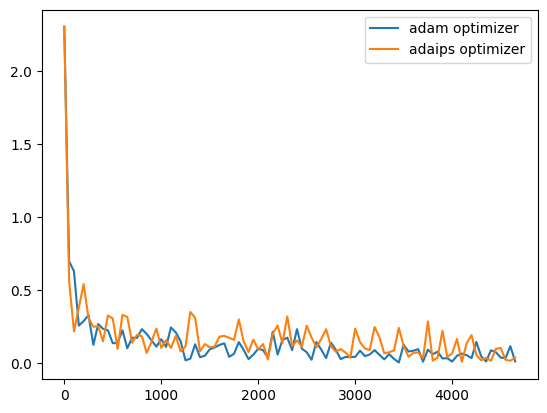

In [56]:
models = [
    (adamModel, 'adam optimizer'), 
    (ipsModel, 'ips optimizer'), 
    (ipsDecayModel, 'ips decay optimizer'),
    (adaIpsModel, 'adaips optimizer')
]
focus = [adaIpsModel, adamModel]
interval = 50
for model in models:
    if model[0] not in focus: continue
    plt.plot(
        [i for i, loss in enumerate(model[0].losses) if i % interval == 0], 
        [loss for i, loss in enumerate(model[0].losses) if i % interval == 0], 
        label=model[1],
        alpha=0.5 if model[0] not in focus else 1
    )

plt.legend()
plt.show()

In [17]:
(len(trainset) / 64) * 2
ipsOptimizer.step_count
1876/(len(trainset) / 64)

2.0010666666666665